Test of NN 

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Keras common configuration
import os
from keras.backend import set_image_dim_ordering

os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32,optimizer=fast_compile'
set_image_dim_ordering('th')

print("Keras user configuration is setup")

Using Theano backend.


Keras user configuration is setup


In [3]:
from keras.layers import Convolution2D
from keras.models import Sequential, Model
from keras.optimizers import Adam


What happens between image channels when convolution is computed :

- convolution filter is applied on each channel -> we obtain `n_channels` of images
- resulting image is computed as weighted sum of `n_channels` images:

    `out = conv_img[0] * w[0] + conv_img[1] * w[1] + ... conv_img[n_channels] * w[n_channels]`


In [6]:
input_img = np.zeros((100, 100, 4), dtype=np.uint8)
for i in range(1, input_img.shape[2]):
    input_img[:,:,i] = i

input_img[20:40,20:40,:] = 0

0 3


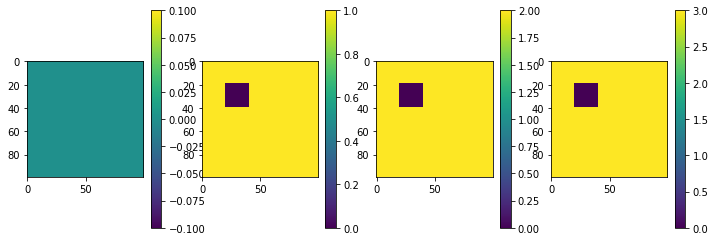

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(141)
plt.imshow(input_img[:,:,0])
plt.colorbar()
plt.subplot(142)
plt.imshow(input_img[:,:,1])
plt.colorbar()
plt.subplot(143)
plt.imshow(input_img[:,:,2])
plt.colorbar()
plt.subplot(144)
plt.imshow(input_img[:,:,3])
plt.colorbar()


print input_img.min(), input_img.max()

Number of weights in Convolution2D:
    - n_filters * kernel_width * kernel_height * input_n_channel + n_filters

In [6]:
weights = np.ones((5,4,1,1))
weights[:,0,:,:] = 0
weights[:,1,:,:] = 1
weights[:,2,:,:] = 2
weights[:,3,:,:] = 3
b = np.zeros((5))
model = Sequential()
model.add(Convolution2D(5, 1, 1, input_shape=(4,100,100), weights=[weights, b], border_mode='same', name='conv'))

In [7]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
inputs = input_img.transpose([2,0,1])
output_img = model.predict(inputs[None,:,:,:])

In [9]:
output_img.shape

(1, 5, 100, 100)

In [10]:
conv_layer = model.get_layer('conv')

In [11]:
conv_layer.W.eval().shape, conv_layer.b.eval().shape

((5, 4, 1, 1), (5,))

0.0 14.0


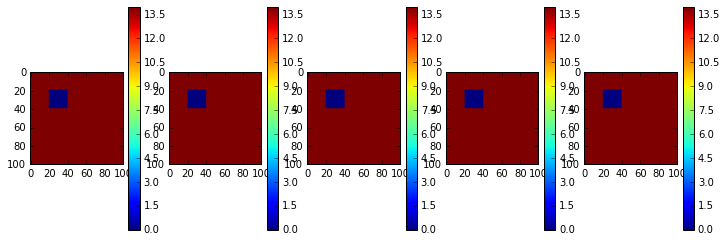

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(151)
plt.imshow(output_img[0,0,:,:])
plt.colorbar()
plt.subplot(152)
plt.imshow(output_img[0,1,:,:])
plt.colorbar()
plt.subplot(153)
plt.imshow(output_img[0,2,:,:])
plt.colorbar()
plt.subplot(154)
plt.imshow(output_img[0,3,:,:])
plt.colorbar()
plt.subplot(155)
plt.imshow(output_img[0,4,:,:])
plt.colorbar()

print output_img.min(), output_img.max()

In [13]:
a = [0, 1, 2, 3]
b = [0, 1, 2, 3]
np.dot(a, b)

14

How to multiply channels ?

$$
O_1 = \sum w_i c_i \cdot \frac{1}{\sum w'_i c_i} + \sum w_i c_i \cdot \sum w'_i c_i
$$

$$
O_2 = \sum w_i c_i \cdot \sum \frac{w'_i}{c_i}
$$

$$
O_3 = \sum w_i c_i + \sum w_i c_i \cdot \sum \frac{w'_i}{c_i} + \sum w_i c_i \cdot \sum w'_i c_i
$$

----

$$
I = \left[ c_0, c_1, ..., c_n \right], \, \text{where} \, c_i \,\text{is a matrix }[h,w]
$$

$$
 C_1 = \left[ C_1(0), C_1(2), ..., C_1(n^1_f) \right], \, \text{where} \, C_1(k) = \sum_i w^k_{1,i} c_i,
$$

$$
 C_2 = \left[ C_2(0), C_2(2), ..., C_2(n^2_f) \right], \, \text{where} \, C_2(k) = \sum_i w^k_{2,i} C_1(i),
$$
$$
C_2(k) = \sum_i w^k_{2,i} \sum_j w^k_{1,j} c_i,
$$



In [6]:
from keras.layers import Input, MaxPooling2D, UpSampling2D, Convolution2D, merge, Reshape, Activation, BatchNormalization
from keras import backend as K
from keras.engine.topology import Layer
from keras.regularizers import l2

In [51]:
class Inverse(Layer):
    """Inverse Layer : 1/x """
    def __init__(self, **kwargs):
        super(Inverse, self).__init__(**kwargs)
        
    def call(self, x, mask=None):
        x = x + K.min(x) + 100.0
        eps = K.variable(value=K.epsilon())
        x = K.pow(x + eps, -1.0)
        mean = K.mean(x)
        std = K.std(x)
        x -= mean
        x /= std
        return x

    def get_output_shape_for(self, input_shape):
        return input_shape
    
    
class Normalization(Layer):
    """Normalization layer : x -> (x - mean)/std """
    def __init__(self, **kwargs):
        super(Normalization, self).__init__(**kwargs)
        
    def call(self, x, mask=None):
        mean = K.mean(x)
        std = K.std(x)
        x -= mean
        x /= std
        return x

    def get_output_shape_for(self, input_shape):
        return input_shape      

In [150]:
def conv(input_layer, n_filters_0=16, deep=False, l=0.01):
    """
    """
    x = Convolution2D(n_filters_0, 3, 3,
                      activation='elu',
                      init='he_normal',
                      W_regularizer=l2(l),
                      border_mode='same')(input_layer)
    if deep:
        x = Convolution2D(2 * n_filters_0, 3, 3,
                          activation='elu',
                          init='he_normal',
                          W_regularizer=l2(l),
                          border_mode='same')(x)
    return x    

def conv_downsample(input_layer, **kwargs):    
    """
    """
    x = conv(input_layer, **kwargs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x    


def ratio(input_layer, base_unit, **kwargs):
    """
    x -> (x1 * 1/x2)
    """
    inverse_layer = Inverse()(input_layer)

    x1 = base_unit(input_layer, **kwargs)
    x2 = base_unit(inverse_layer, **kwargs)
    x12 = merge([x1, x2], mode='mul')
    x12 = Normalization()(x12)
    
    return x12
    

def composition(input_layer, base_unit, **kwargs):
    """
    x -> x1 ; (x2 * 1/x3) ; (x4 * x5) ; 1/x6
    """
    inverse_layer = Inverse()(input_layer)

    x1 = base_unit(input_layer, **kwargs)
    x2 = base_unit(input_layer, **kwargs)
    x3 = base_unit(inverse_layer, **kwargs)
    x4 = base_unit(input_layer, **kwargs)
    x5 = base_unit(input_layer, **kwargs)
    x6 = base_unit(inverse_layer, **kwargs)

    x16 = merge([x1, x6], mode='sum')
    x23 = merge([x2, x3], mode='mul')
    x45 = merge([x4, x5], mode='mul')

    x1236 = merge([x16, x23], mode='sum')
    x123456 = merge([x1236, x45], mode='sum')

    x123456 = Normalization()(x123456)
    return x123456


def upsample_merge(x_small, x_large):
    x_small = UpSampling2D(size=(2, 2))(x_small)
    return merge([x_small, x_large], mode='concat', concat_axis=1)


def simple_end_cap(input_layer, n_classes, input_height, input_width):
    x = Convolution2D(n_classes, 1, 1)(input_layer)
    x = Reshape((n_classes, input_height * input_width))(x)
    x = Activation('softmax')(x)
    x = Reshape((n_classes, input_height, input_width))(x)   
    
    return x

Model : 

In [151]:
n_filters_0 = 2**3
n_classes = 8
input_height = 256
input_width = 256
n_channels = 5
deep=False

inputs = Input((n_channels, input_height, input_width))
x = inputs

x = ratio(x, conv, n_filters_0=n_filters_0, deep=deep)
# x = Inverse()(x)
outputs = simple_end_cap(x, n_classes, input_width, input_height)

model = Model(input=inputs, output=outputs)

# # Downsample and store
# x = composition(x, conv, n_filters_0=n_filters_0)
# x0 = x
# x = composition(x, conv_downsample, n_filters_0=n_filters_0*2)
# x1 = x
# x = composition(x, conv_downsample, n_filters_0=n_filters_0*4)
# x2 = x
# x = composition(x, conv_downsample, n_filters_0=n_filters_0*8)
# x3 = x
# x = composition(x, conv_downsample, n_filters_0=n_filters_0*16)

# x = conv(x, n_filters_0=n_filters_0*32)

# # Upsample and merge
# x = upsample_merge(x, x3)
# x = composition(x, conv, n_filters_0=n_filters_0*16)
# x = upsample_merge(x, x2)
# x = composition(x, conv, n_filters_0=n_filters_0*8)
# x = upsample_merge(x, x1)
# x = composition(x, conv, n_filters_0=n_filters_0*4)
# x = upsample_merge(x, x0)
# x = composition(x, conv, n_filters_0=n_filters_0*2)

# outputs = Convolution2D(n_classes, 1, 1)(x)
# outputs = Reshape((n_classes, input_height * input_width))(outputs)
# outputs = Activation('softmax')(outputs)
# outputs = Reshape((n_classes, input_height, input_width))(outputs)

model = Model(input=inputs, output=outputs)

In [152]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_17 (InputLayer)            (None, 5, 256, 256)   0                                            
____________________________________________________________________________________________________
inverse_16 (Inverse)             (None, 5, 256, 256)   0           input_17[0][0]                   
____________________________________________________________________________________________________
convolution2d_17 (Convolution2D) (None, 8, 256, 256)   368         input_17[0][0]                   
____________________________________________________________________________________________________
convolution2d_18 (Convolution2D) (None, 8, 256, 256)   368         inverse_16[0][0]                 
___________________________________________________________________________________________

In [153]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [171]:
batch_size = 5
inputs = np.zeros((batch_size, n_channels, input_height, input_width), dtype=np.float)
for j in range(batch_size):
    for i in range(1, inputs.shape[1]):
        inputs[j,i,:,:] = i + j*i - j
inputs[:,:,20:40,20:40] = 0   

print inputs.min(), inputs.max()

0.0 16.0


In [172]:
output_img = model.predict(inputs)
output_img.shape, output_img.min(), output_img.max()

((5L, 8L, 256L, 256L), 1.2864788e-06, 0.00010230044)

In [173]:
x = inputs.astype(np.float)
mean = np.mean(x)
std = np.std(x)
x -= mean
x /= std
print x.min(), x.max()

-0.991880177933 2.63710640907


In [174]:
y = np.random.rand(batch_size, n_classes, input_height, input_width)
print y.min(), y.max()

5.67383233729e-08 0.999999238436


In [198]:
hist = model.fit(inputs, y, nb_epoch=5, batch_size=batch_size, verbose=2)

Epoch 1/5
0s - loss: 709.7665 - acc: 0.0035
Epoch 2/5
0s - loss: 709.7658 - acc: 0.0035
Epoch 3/5
0s - loss: 709.7652 - acc: 0.0035
Epoch 4/5
0s - loss: 709.7645 - acc: 0.0034
Epoch 5/5
0s - loss: 709.7637 - acc: 0.0034


In [149]:
layer = model.get_layer(index=2)
print layer.weights
print layer.W.eval()[0,0,:,:]

layer = model.get_layer(index=3)
print layer.weights
print layer.W.eval()[0,0,:,:]
layer = model.get_layer(index=6)
print layer.weights
print layer.W.eval()[0,0,:,:]

[convolution2d_14_W, convolution2d_14_b]
CudaNdarray([[-0.06100256 -0.00921282 -0.11241958]
 [ 0.09899317  0.0441178   0.00341133]
 [-0.11492583 -0.00104379 -0.00670358]])
[convolution2d_15_W, convolution2d_15_b]
CudaNdarray([[ 0.14700219 -0.09424449 -0.11693664]
 [-0.00486277 -0.1343445   0.11395196]
 [-0.04153481 -0.05412144 -0.07908625]])
[convolution2d_16_W, convolution2d_16_b]
CudaNdarray([[-0.43660477]])


In [20]:
a = 2*K.ones((3, 5, 10,10))
b = 3*K.ones((3, 5, 10,10))

In [21]:
c = K.concatenate([a, b], axis=1)

In [22]:
K.shape(c).eval()

array([ 3, 10, 10, 10])

In [231]:
b = K.cast(K.greater(a, 0.5),'float32')

In [232]:
b.eval()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [233]:
c = a * b

In [234]:
c.eval()

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.55000001,  0.60000002,  0.64999998,  0.69999999,
        0.75      ,  0.80000001,  0.85000002,  0.89999998,  0.94999999], dtype=float32)